In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [7]:
# 생성자 모델 만들기

generator = models.Sequential()
generator.add(layers.Dense(7*7*128, input_dim=100,
# 하이퍼 파라미터 하기 위해 layers 사용 또한 더 정밀한 기울기를 구하기 위해 LeakyReLU사용
             activation=layers.LeakyReLU(0.2)))

# BatchNormalization(): 데이터 스케일링 (0 ~ 1)
generator.add(layers.BatchNormalization())

# 이미지 7*7로 구성
generator.add(layers.Reshape((7, 7, 128)))

# 
generator.add(layers.UpSampling2D())

# padding='same': 출력이 원본사이즈와 같게 컨볼루션함
generator.add(layers.Conv2D(64, kernel_size=5, padding='same'))
generator.add(layers.BatchNormalization())

generator.add(layers.Activation(layers.LeakyReLU(0.2)))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
generator.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_5 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_6 (Batc  (None, 14, 14, 64)      

In [9]:
# 판별자 모델 만들기

discriminator = models.Sequential()

# 컨볼루션 설정이 1칸씩 움직이는 것이 아닌 2칸씩 움직여 듬섬, 듬섬 출력이 나옴
discriminator.add(layers.Conv2D(64, kernel_size=5, input_shape=(28, 28, 1),
                              strides=2, padding='same'))

discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, kernel_size=5,strides=2, padding='same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid'))

# generator 판별 목적이기 때문에 metrics 가 없다.
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# generator 판별 시 discriminator 학습에 의해 데이터가 뭉개짐 그걸 막기위해 False
discriminator.trainable = False

discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_4 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_5 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [14]:
# 생성자와 판별자를 연결시키고 학습을 진행하며 기타 여러 가지 옵션을 설정하는 순서
ginput = layers.Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_6 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [17]:
if not os.path.exists('data/gan_images'):
    os.mkdir('data/gan_images')

def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
    
    # generator의 activation 설정이 tanh(-1 ~ 1) 값이 나오므로 여기서도 그 설정을 해야함
    X_train = (X_train - 127.5) / 127.5 
    
    # 정답용 target
    true = np.ones((batch_size, 1))
    
    fake = np.zeros((batch_size, 1))
    
    # 0부터 X_train 사이의 값을 batch_size 값 만큼 뽑기
    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        # 진짜그림과 판별해서 생긴 오차값 : d_loss_real
        d_loss_real = discriminator.train_on_batch(imgs, true)
        
        # 0에서 1사이의 batch_size 값만큼 100
        noise = np.random.normal(0, 1, (batch_size, 100))
        
        gen_imgs = generator.predict(noise)
        
        # 가짜그림과 판별해서 생긴 오차값 : d_loss_fake
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        # 진짜그림과 가짜그림 간 오차평균 구하기
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
        
        if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("data/gan_images/gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 32ms/step
epoch:0  d_loss:3.5504  g_loss:8.5172
1/1 [==============================] - 0s 30ms/step
epoch:1  d_loss:0.8379  g_loss:18.4209
1/1 [==============================] - 0s 30ms/step
epoch:2  d_loss:2.7812  g_loss:20.4051
1/1 [==============================] - 0s 31ms/step
epoch:3  d_loss:1.3379  g_loss:17.8007
1/1 [==============================] - 0s 30ms/step
epoch:4  d_loss:1.5903  g_loss:15.5328
1/1 [==============================] - 0s 30ms/step
epoch:5  d_loss:0.9844  g_loss:11.0860
1/1 [==============================] - 0s 30ms/step
epoch:6  d_loss:0.8599  g_loss:10.2946
1/1 [==============================] - 0s 29ms/step
epoch:7  d_loss:0.2318  g_loss:12.5967
1/1 [==============================] - 0s 30ms/step
epoch:8  d_loss:0.1720  g_loss:12.0015
1/1 [==============================] - 0s 35ms/step
epoch:9  d_loss:0.2512  g_loss:11.8368
1/1 [==============================] - 0s 30ms/step
epoch:10  d_loss:0.3710  g_loss:10.0160

1/1 [==============================] - 0s 31ms/step
epoch:89  d_loss:0.2809  g_loss:5.1848
1/1 [==============================] - 0s 30ms/step
epoch:90  d_loss:0.3793  g_loss:7.4280
1/1 [==============================] - 0s 31ms/step
epoch:91  d_loss:0.1166  g_loss:8.2325
1/1 [==============================] - 0s 30ms/step
epoch:92  d_loss:0.2280  g_loss:7.7263
1/1 [==============================] - 0s 30ms/step
epoch:93  d_loss:0.3127  g_loss:6.6927
1/1 [==============================] - 0s 35ms/step
epoch:94  d_loss:0.3197  g_loss:4.6018
1/1 [==============================] - 0s 31ms/step
epoch:95  d_loss:0.3898  g_loss:4.1681
1/1 [==============================] - 0s 31ms/step
epoch:96  d_loss:0.4761  g_loss:5.0031
1/1 [==============================] - 0s 31ms/step
epoch:97  d_loss:0.2523  g_loss:6.5708
1/1 [==============================] - 0s 31ms/step
epoch:98  d_loss:0.2825  g_loss:8.4844
1/1 [==============================] - 0s 31ms/step
epoch:99  d_loss:0.3781  g_loss:6.5317

1/1 [==============================] - 0s 32ms/step
epoch:178  d_loss:0.1881  g_loss:4.0862
1/1 [==============================] - 0s 30ms/step
epoch:179  d_loss:0.0964  g_loss:3.1859
1/1 [==============================] - 0s 31ms/step
epoch:180  d_loss:0.2438  g_loss:3.8505
1/1 [==============================] - 0s 42ms/step
epoch:181  d_loss:0.2406  g_loss:4.2946
1/1 [==============================] - 0s 30ms/step
epoch:182  d_loss:0.1845  g_loss:4.5458
1/1 [==============================] - 0s 31ms/step
epoch:183  d_loss:0.1214  g_loss:4.7141
1/1 [==============================] - 0s 30ms/step
epoch:184  d_loss:0.1530  g_loss:5.3713
1/1 [==============================] - 0s 31ms/step
epoch:185  d_loss:0.1085  g_loss:4.9430
1/1 [==============================] - 0s 31ms/step
epoch:186  d_loss:0.2606  g_loss:4.3818
1/1 [==============================] - 0s 41ms/step
epoch:187  d_loss:0.1749  g_loss:4.2067
1/1 [==============================] - 0s 30ms/step
epoch:188  d_loss:0.2115  g_

1/1 [==============================] - 0s 31ms/step
epoch:266  d_loss:0.1218  g_loss:3.9485
1/1 [==============================] - 0s 30ms/step
epoch:267  d_loss:0.0943  g_loss:4.1029
1/1 [==============================] - 0s 41ms/step
epoch:268  d_loss:0.2311  g_loss:3.3627
1/1 [==============================] - 0s 30ms/step
epoch:269  d_loss:0.1057  g_loss:3.4574
1/1 [==============================] - 0s 36ms/step
epoch:270  d_loss:0.0783  g_loss:5.1417
1/1 [==============================] - 0s 30ms/step
epoch:271  d_loss:0.0840  g_loss:4.4090
1/1 [==============================] - 0s 34ms/step
epoch:272  d_loss:0.2820  g_loss:3.6127
1/1 [==============================] - 0s 35ms/step
epoch:273  d_loss:0.1591  g_loss:3.6364
1/1 [==============================] - 0s 35ms/step
epoch:274  d_loss:0.0843  g_loss:4.8622
1/1 [==============================] - 0s 31ms/step
epoch:275  d_loss:0.1340  g_loss:5.0550
1/1 [==============================] - 0s 36ms/step
epoch:276  d_loss:0.0990  g_

1/1 [==============================] - 0s 30ms/step
epoch:355  d_loss:0.1101  g_loss:5.0822
1/1 [==============================] - 0s 30ms/step
epoch:356  d_loss:0.0242  g_loss:5.9772
1/1 [==============================] - 0s 31ms/step
epoch:357  d_loss:0.0740  g_loss:5.8772
1/1 [==============================] - 0s 39ms/step
epoch:358  d_loss:0.0679  g_loss:5.5877
1/1 [==============================] - 0s 30ms/step
epoch:359  d_loss:0.1192  g_loss:5.5872
1/1 [==============================] - 0s 30ms/step
epoch:360  d_loss:0.0514  g_loss:4.9150
1/1 [==============================] - 0s 31ms/step
epoch:361  d_loss:0.2061  g_loss:4.0768
1/1 [==============================] - 0s 31ms/step
epoch:362  d_loss:0.0549  g_loss:4.6596
1/1 [==============================] - 0s 30ms/step
epoch:363  d_loss:0.0352  g_loss:5.8451
1/1 [==============================] - 0s 41ms/step
epoch:364  d_loss:0.0540  g_loss:5.7399
1/1 [==============================] - 0s 29ms/step
epoch:365  d_loss:0.0990  g_

1/1 [==============================] - 0s 30ms/step
epoch:443  d_loss:0.2179  g_loss:5.4950
1/1 [==============================] - 0s 30ms/step
epoch:444  d_loss:0.0848  g_loss:4.3891
1/1 [==============================] - 0s 31ms/step
epoch:445  d_loss:0.1705  g_loss:3.9924
1/1 [==============================] - 0s 30ms/step
epoch:446  d_loss:0.0499  g_loss:4.1342
1/1 [==============================] - 0s 30ms/step
epoch:447  d_loss:0.0611  g_loss:5.8827
1/1 [==============================] - 0s 30ms/step
epoch:448  d_loss:0.1906  g_loss:6.3125
1/1 [==============================] - 0s 30ms/step
epoch:449  d_loss:0.0867  g_loss:5.0987
1/1 [==============================] - 0s 31ms/step
epoch:450  d_loss:0.0795  g_loss:5.4042
1/1 [==============================] - 0s 31ms/step
epoch:451  d_loss:0.1190  g_loss:3.8284
1/1 [==============================] - 0s 31ms/step
epoch:452  d_loss:0.1660  g_loss:3.9082
1/1 [==============================] - 0s 30ms/step
epoch:453  d_loss:0.0560  g_

1/1 [==============================] - 0s 37ms/step
epoch:532  d_loss:0.0861  g_loss:4.2687
1/1 [==============================] - 0s 40ms/step
epoch:533  d_loss:0.0255  g_loss:4.3750
1/1 [==============================] - 0s 33ms/step
epoch:534  d_loss:0.2086  g_loss:5.2271
1/1 [==============================] - 0s 31ms/step
epoch:535  d_loss:0.0603  g_loss:6.4005
1/1 [==============================] - 0s 30ms/step
epoch:536  d_loss:0.0531  g_loss:6.7571
1/1 [==============================] - 0s 30ms/step
epoch:537  d_loss:0.1127  g_loss:4.8226
1/1 [==============================] - 0s 39ms/step
epoch:538  d_loss:0.0776  g_loss:3.9241
1/1 [==============================] - 0s 30ms/step
epoch:539  d_loss:0.2477  g_loss:3.2376
1/1 [==============================] - 0s 31ms/step
epoch:540  d_loss:0.0307  g_loss:5.3196
1/1 [==============================] - 0s 32ms/step
epoch:541  d_loss:0.1390  g_loss:4.5907
1/1 [==============================] - 0s 31ms/step
epoch:542  d_loss:0.0747  g_

1/1 [==============================] - 0s 30ms/step
epoch:620  d_loss:0.1598  g_loss:5.4033
1/1 [==============================] - 0s 30ms/step
epoch:621  d_loss:0.1665  g_loss:4.6304
1/1 [==============================] - 0s 31ms/step
epoch:622  d_loss:0.1709  g_loss:3.8377
1/1 [==============================] - 0s 30ms/step
epoch:623  d_loss:0.1850  g_loss:2.8531
1/1 [==============================] - 0s 42ms/step
epoch:624  d_loss:0.1457  g_loss:4.0510
1/1 [==============================] - 0s 42ms/step
epoch:625  d_loss:0.0345  g_loss:5.3408
1/1 [==============================] - 0s 31ms/step
epoch:626  d_loss:0.0977  g_loss:7.1559
1/1 [==============================] - 0s 31ms/step
epoch:627  d_loss:0.0338  g_loss:6.1609
1/1 [==============================] - 0s 31ms/step
epoch:628  d_loss:0.2447  g_loss:5.3608
1/1 [==============================] - 0s 31ms/step
epoch:629  d_loss:0.2398  g_loss:4.0302
1/1 [==============================] - 0s 31ms/step
epoch:630  d_loss:0.0913  g_

1/1 [==============================] - 0s 31ms/step
epoch:709  d_loss:0.4326  g_loss:2.6497
1/1 [==============================] - 0s 44ms/step
epoch:710  d_loss:0.3665  g_loss:3.5577
1/1 [==============================] - 0s 35ms/step
epoch:711  d_loss:0.7322  g_loss:2.3398
1/1 [==============================] - 0s 35ms/step
epoch:712  d_loss:0.8457  g_loss:2.4903
1/1 [==============================] - 0s 36ms/step
epoch:713  d_loss:0.8460  g_loss:2.3277
1/1 [==============================] - 0s 30ms/step
epoch:714  d_loss:1.0270  g_loss:2.2170
1/1 [==============================] - 0s 32ms/step
epoch:715  d_loss:1.2145  g_loss:2.7300
1/1 [==============================] - 0s 31ms/step
epoch:716  d_loss:0.4331  g_loss:4.7204
1/1 [==============================] - 0s 34ms/step
epoch:717  d_loss:0.7025  g_loss:4.8949
1/1 [==============================] - 0s 31ms/step
epoch:718  d_loss:0.5236  g_loss:4.0917
1/1 [==============================] - 0s 36ms/step
epoch:719  d_loss:0.4754  g_

1/1 [==============================] - 0s 31ms/step
epoch:798  d_loss:0.5084  g_loss:2.8549
1/1 [==============================] - 0s 31ms/step
epoch:799  d_loss:0.4293  g_loss:2.7674
1/1 [==============================] - 0s 41ms/step
epoch:800  d_loss:0.5637  g_loss:2.5340
1/1 [==============================] - 0s 31ms/step
epoch:801  d_loss:0.4989  g_loss:2.7276
1/1 [==============================] - 0s 33ms/step
epoch:802  d_loss:0.6205  g_loss:2.4143
1/1 [==============================] - 0s 31ms/step
epoch:803  d_loss:0.4933  g_loss:1.9802
1/1 [==============================] - 0s 31ms/step
epoch:804  d_loss:0.3530  g_loss:2.2767
1/1 [==============================] - 0s 31ms/step
epoch:805  d_loss:0.4468  g_loss:2.5549
1/1 [==============================] - 0s 38ms/step
epoch:806  d_loss:0.5435  g_loss:2.2571
1/1 [==============================] - 0s 32ms/step
epoch:807  d_loss:0.3168  g_loss:2.3544
1/1 [==============================] - 0s 31ms/step
epoch:808  d_loss:0.4215  g_

1/1 [==============================] - 0s 31ms/step
epoch:886  d_loss:0.6010  g_loss:1.6280
1/1 [==============================] - 0s 30ms/step
epoch:887  d_loss:0.4107  g_loss:2.5768
1/1 [==============================] - 0s 32ms/step
epoch:888  d_loss:0.5262  g_loss:2.5629
1/1 [==============================] - 0s 30ms/step
epoch:889  d_loss:0.4558  g_loss:1.8067
1/1 [==============================] - 0s 33ms/step
epoch:890  d_loss:0.4094  g_loss:1.8738
1/1 [==============================] - 0s 30ms/step
epoch:891  d_loss:0.3838  g_loss:1.8955
1/1 [==============================] - 0s 30ms/step
epoch:892  d_loss:0.3596  g_loss:1.9871
1/1 [==============================] - 0s 31ms/step
epoch:893  d_loss:0.3832  g_loss:1.9922
1/1 [==============================] - 0s 30ms/step
epoch:894  d_loss:0.3159  g_loss:2.7147
1/1 [==============================] - 0s 31ms/step
epoch:895  d_loss:0.2810  g_loss:2.3000
1/1 [==============================] - 0s 32ms/step
epoch:896  d_loss:0.3431  g_

1/1 [==============================] - 0s 35ms/step
epoch:975  d_loss:0.3118  g_loss:2.4417
1/1 [==============================] - 0s 31ms/step
epoch:976  d_loss:0.2757  g_loss:2.3428
1/1 [==============================] - 0s 36ms/step
epoch:977  d_loss:0.3634  g_loss:2.2369
1/1 [==============================] - 0s 37ms/step
epoch:978  d_loss:0.4547  g_loss:2.3530
1/1 [==============================] - 0s 34ms/step
epoch:979  d_loss:0.3990  g_loss:1.6163
1/1 [==============================] - 0s 31ms/step
epoch:980  d_loss:0.3699  g_loss:1.5466
1/1 [==============================] - 0s 30ms/step
epoch:981  d_loss:0.3596  g_loss:2.0236
1/1 [==============================] - 0s 30ms/step
epoch:982  d_loss:0.4187  g_loss:1.7532
1/1 [==============================] - 0s 30ms/step
epoch:983  d_loss:0.4335  g_loss:2.3048
1/1 [==============================] - 0s 31ms/step
epoch:984  d_loss:0.3080  g_loss:2.4284
1/1 [==============================] - 0s 31ms/step
epoch:985  d_loss:0.4269  g_

1/1 [==============================] - 0s 31ms/step
epoch:1063  d_loss:0.2404  g_loss:2.0409
1/1 [==============================] - 0s 31ms/step
epoch:1064  d_loss:0.3388  g_loss:1.9047
1/1 [==============================] - 0s 31ms/step
epoch:1065  d_loss:0.2880  g_loss:2.3711
1/1 [==============================] - 0s 40ms/step
epoch:1066  d_loss:0.1242  g_loss:2.9471
1/1 [==============================] - 0s 30ms/step
epoch:1067  d_loss:0.2033  g_loss:3.2360
1/1 [==============================] - 0s 30ms/step
epoch:1068  d_loss:0.2317  g_loss:3.8478
1/1 [==============================] - 0s 32ms/step
epoch:1069  d_loss:0.4226  g_loss:2.9380
1/1 [==============================] - 0s 30ms/step
epoch:1070  d_loss:0.2668  g_loss:2.1785
1/1 [==============================] - 0s 31ms/step
epoch:1071  d_loss:0.4023  g_loss:2.2579
1/1 [==============================] - 0s 41ms/step
epoch:1072  d_loss:0.4162  g_loss:1.8689
1/1 [==============================] - 0s 30ms/step
epoch:1073  d_loss

1/1 [==============================] - 0s 32ms/step
epoch:1151  d_loss:0.5277  g_loss:1.9729
1/1 [==============================] - 0s 30ms/step
epoch:1152  d_loss:0.5169  g_loss:1.4075
1/1 [==============================] - 0s 32ms/step
epoch:1153  d_loss:0.4492  g_loss:1.6607
1/1 [==============================] - 0s 31ms/step
epoch:1154  d_loss:0.5338  g_loss:1.9082
1/1 [==============================] - 0s 32ms/step
epoch:1155  d_loss:0.5753  g_loss:1.7251
1/1 [==============================] - 0s 32ms/step
epoch:1156  d_loss:0.5775  g_loss:1.8253
1/1 [==============================] - 0s 31ms/step
epoch:1157  d_loss:0.4216  g_loss:1.9533
1/1 [==============================] - 0s 31ms/step
epoch:1158  d_loss:0.5278  g_loss:1.6671
1/1 [==============================] - 0s 30ms/step
epoch:1159  d_loss:0.5037  g_loss:1.6458
1/1 [==============================] - 0s 30ms/step
epoch:1160  d_loss:0.4678  g_loss:1.5716
1/1 [==============================] - 0s 41ms/step
epoch:1161  d_loss

epoch:1238  d_loss:0.3663  g_loss:1.9827
1/1 [==============================] - 0s 33ms/step
epoch:1239  d_loss:0.3265  g_loss:2.0758
1/1 [==============================] - 0s 36ms/step
epoch:1240  d_loss:0.3203  g_loss:2.1303
1/1 [==============================] - 0s 31ms/step
epoch:1241  d_loss:0.3524  g_loss:2.4401
1/1 [==============================] - 0s 31ms/step
epoch:1242  d_loss:0.3296  g_loss:2.3052
1/1 [==============================] - 0s 31ms/step
epoch:1243  d_loss:0.6358  g_loss:2.0791
1/1 [==============================] - 0s 32ms/step
epoch:1244  d_loss:0.3895  g_loss:1.9293
1/1 [==============================] - 0s 31ms/step
epoch:1245  d_loss:0.2683  g_loss:2.0281
1/1 [==============================] - 0s 31ms/step
epoch:1246  d_loss:0.4210  g_loss:1.9289
1/1 [==============================] - 0s 30ms/step
epoch:1247  d_loss:0.4430  g_loss:2.1054
1/1 [==============================] - 0s 34ms/step
epoch:1248  d_loss:0.3677  g_loss:2.0433
1/1 [========================

1/1 [==============================] - 0s 32ms/step
epoch:1327  d_loss:0.3955  g_loss:2.4049
1/1 [==============================] - 0s 37ms/step
epoch:1328  d_loss:0.4015  g_loss:2.3340
1/1 [==============================] - 0s 32ms/step
epoch:1329  d_loss:0.2890  g_loss:2.0858
1/1 [==============================] - 0s 31ms/step
epoch:1330  d_loss:0.3356  g_loss:2.5121
1/1 [==============================] - 0s 30ms/step
epoch:1331  d_loss:0.3812  g_loss:1.9578
1/1 [==============================] - 0s 31ms/step
epoch:1332  d_loss:0.3465  g_loss:2.1702
1/1 [==============================] - 0s 31ms/step
epoch:1333  d_loss:0.2885  g_loss:2.1078
1/1 [==============================] - 0s 31ms/step
epoch:1334  d_loss:0.3093  g_loss:2.3751
1/1 [==============================] - 0s 31ms/step
epoch:1335  d_loss:0.3019  g_loss:3.0510
1/1 [==============================] - 0s 31ms/step
epoch:1336  d_loss:0.4504  g_loss:2.5494
1/1 [==============================] - 0s 31ms/step
epoch:1337  d_loss

epoch:1414  d_loss:0.4377  g_loss:1.3598
1/1 [==============================] - 0s 31ms/step
epoch:1415  d_loss:0.3392  g_loss:1.7823
1/1 [==============================] - 0s 31ms/step
epoch:1416  d_loss:0.4276  g_loss:1.5368
1/1 [==============================] - 0s 43ms/step
epoch:1417  d_loss:0.3796  g_loss:2.1963
1/1 [==============================] - 0s 31ms/step
epoch:1418  d_loss:0.3611  g_loss:2.2148
1/1 [==============================] - 0s 36ms/step
epoch:1419  d_loss:0.4507  g_loss:2.3519
1/1 [==============================] - 0s 33ms/step
epoch:1420  d_loss:0.4090  g_loss:2.0500
1/1 [==============================] - 0s 35ms/step
epoch:1421  d_loss:0.4692  g_loss:1.8005
1/1 [==============================] - 0s 31ms/step
epoch:1422  d_loss:0.3639  g_loss:1.7339
1/1 [==============================] - 0s 30ms/step
epoch:1423  d_loss:0.3254  g_loss:2.1579
1/1 [==============================] - 0s 30ms/step
epoch:1424  d_loss:0.2778  g_loss:2.4894
1/1 [========================

1/1 [==============================] - 0s 30ms/step
epoch:1503  d_loss:0.4857  g_loss:2.1526
1/1 [==============================] - 0s 36ms/step
epoch:1504  d_loss:0.5295  g_loss:2.0069
1/1 [==============================] - 0s 30ms/step
epoch:1505  d_loss:0.4810  g_loss:2.2875
1/1 [==============================] - 0s 41ms/step
epoch:1506  d_loss:0.3998  g_loss:2.2697
1/1 [==============================] - 0s 31ms/step
epoch:1507  d_loss:0.3734  g_loss:2.0947
1/1 [==============================] - 0s 31ms/step
epoch:1508  d_loss:0.4679  g_loss:2.2371
1/1 [==============================] - 0s 31ms/step
epoch:1509  d_loss:0.5186  g_loss:2.4036
1/1 [==============================] - 0s 31ms/step
epoch:1510  d_loss:0.3683  g_loss:2.1180
1/1 [==============================] - 0s 30ms/step
epoch:1511  d_loss:0.3395  g_loss:2.3355
1/1 [==============================] - 0s 42ms/step
epoch:1512  d_loss:0.2942  g_loss:2.2466
1/1 [==============================] - 0s 30ms/step
epoch:1513  d_loss

1/1 [==============================] - 0s 35ms/step
epoch:1591  d_loss:0.3485  g_loss:2.5012
1/1 [==============================] - 0s 35ms/step
epoch:1592  d_loss:0.2556  g_loss:2.3463
1/1 [==============================] - 0s 36ms/step
epoch:1593  d_loss:0.2755  g_loss:1.9648
1/1 [==============================] - 0s 37ms/step
epoch:1594  d_loss:0.3422  g_loss:2.0730
1/1 [==============================] - 0s 31ms/step
epoch:1595  d_loss:0.3441  g_loss:2.2324
1/1 [==============================] - 0s 35ms/step
epoch:1596  d_loss:0.3162  g_loss:2.7569
1/1 [==============================] - 0s 40ms/step
epoch:1597  d_loss:0.3522  g_loss:2.4533
1/1 [==============================] - 0s 38ms/step
epoch:1598  d_loss:0.3641  g_loss:2.4039
1/1 [==============================] - 0s 31ms/step
epoch:1599  d_loss:0.2713  g_loss:2.2668
1/1 [==============================] - 0s 31ms/step
epoch:1600  d_loss:0.3836  g_loss:2.1583
1/1 [==============================] - 0s 35ms/step
epoch:1601  d_loss

epoch:1678  d_loss:0.5537  g_loss:1.8906
1/1 [==============================] - 0s 30ms/step
epoch:1679  d_loss:0.4128  g_loss:2.2983
1/1 [==============================] - 0s 31ms/step
epoch:1680  d_loss:0.4810  g_loss:1.6702
1/1 [==============================] - 0s 33ms/step
epoch:1681  d_loss:0.4108  g_loss:1.5831
1/1 [==============================] - 0s 32ms/step
epoch:1682  d_loss:0.3965  g_loss:1.9381
1/1 [==============================] - 0s 31ms/step
epoch:1683  d_loss:0.4312  g_loss:1.9964
1/1 [==============================] - 0s 37ms/step
epoch:1684  d_loss:0.5479  g_loss:1.7870
1/1 [==============================] - 0s 34ms/step
epoch:1685  d_loss:0.4687  g_loss:2.0930
1/1 [==============================] - 0s 31ms/step
epoch:1686  d_loss:0.3527  g_loss:1.8629
1/1 [==============================] - 0s 32ms/step
epoch:1687  d_loss:0.5926  g_loss:1.6461
1/1 [==============================] - 0s 30ms/step
epoch:1688  d_loss:0.5144  g_loss:2.0597
1/1 [========================

1/1 [==============================] - 0s 31ms/step
epoch:1767  d_loss:0.2983  g_loss:2.4298
1/1 [==============================] - 0s 31ms/step
epoch:1768  d_loss:0.3675  g_loss:2.3379
1/1 [==============================] - 0s 30ms/step
epoch:1769  d_loss:0.3482  g_loss:2.4227
1/1 [==============================] - 0s 33ms/step
epoch:1770  d_loss:0.4503  g_loss:1.8198
1/1 [==============================] - 0s 35ms/step
epoch:1771  d_loss:0.4664  g_loss:1.8052
1/1 [==============================] - 0s 31ms/step
epoch:1772  d_loss:0.4175  g_loss:1.5919
1/1 [==============================] - 0s 37ms/step
epoch:1773  d_loss:0.3268  g_loss:2.0437
1/1 [==============================] - 0s 33ms/step
epoch:1774  d_loss:0.3675  g_loss:1.8318
1/1 [==============================] - 0s 35ms/step
epoch:1775  d_loss:0.2519  g_loss:2.0718
1/1 [==============================] - 0s 37ms/step
epoch:1776  d_loss:0.2939  g_loss:2.1690
1/1 [==============================] - 0s 30ms/step
epoch:1777  d_loss

epoch:1854  d_loss:0.4483  g_loss:2.1344
1/1 [==============================] - 0s 32ms/step
epoch:1855  d_loss:0.4864  g_loss:2.1144
1/1 [==============================] - 0s 50ms/step
epoch:1856  d_loss:0.3527  g_loss:1.9071
1/1 [==============================] - 0s 32ms/step
epoch:1857  d_loss:0.3405  g_loss:2.2713
1/1 [==============================] - 0s 32ms/step
epoch:1858  d_loss:0.3306  g_loss:2.6058
1/1 [==============================] - 0s 34ms/step
epoch:1859  d_loss:0.3703  g_loss:2.4706
1/1 [==============================] - 0s 31ms/step
epoch:1860  d_loss:0.3370  g_loss:2.7127
1/1 [==============================] - 0s 32ms/step
epoch:1861  d_loss:0.3233  g_loss:2.2962
1/1 [==============================] - 0s 32ms/step
epoch:1862  d_loss:0.3738  g_loss:2.8396
1/1 [==============================] - 0s 33ms/step
epoch:1863  d_loss:0.3916  g_loss:2.7564
1/1 [==============================] - 0s 36ms/step
epoch:1864  d_loss:0.3243  g_loss:2.3821
1/1 [========================

1/1 [==============================] - 0s 31ms/step
epoch:1943  d_loss:0.2888  g_loss:2.6501
1/1 [==============================] - 0s 32ms/step
epoch:1944  d_loss:0.3436  g_loss:2.4649
1/1 [==============================] - 0s 32ms/step
epoch:1945  d_loss:0.4305  g_loss:2.4058
1/1 [==============================] - 0s 31ms/step
epoch:1946  d_loss:0.3897  g_loss:1.5974
1/1 [==============================] - 0s 31ms/step
epoch:1947  d_loss:0.5103  g_loss:1.8439
1/1 [==============================] - 0s 31ms/step
epoch:1948  d_loss:0.3645  g_loss:1.4698
1/1 [==============================] - 0s 34ms/step
epoch:1949  d_loss:0.2451  g_loss:2.1545
1/1 [==============================] - 0s 33ms/step
epoch:1950  d_loss:0.3498  g_loss:2.0005
1/1 [==============================] - 0s 37ms/step
epoch:1951  d_loss:0.4905  g_loss:2.5831
1/1 [==============================] - 0s 31ms/step
epoch:1952  d_loss:0.3519  g_loss:2.0306
1/1 [==============================] - 0s 34ms/step
epoch:1953  d_loss

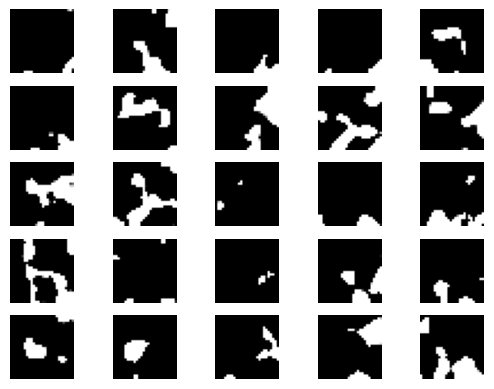

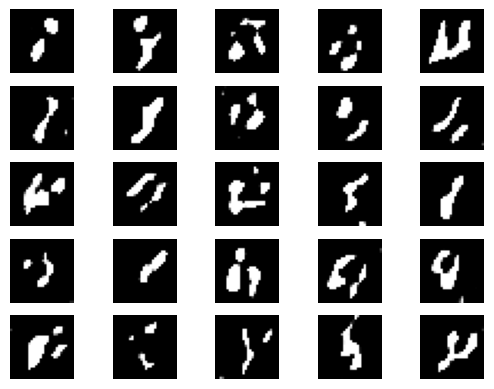

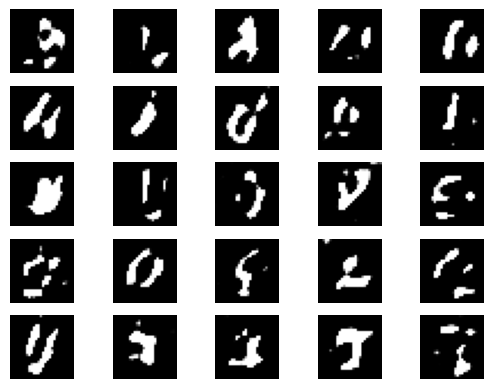

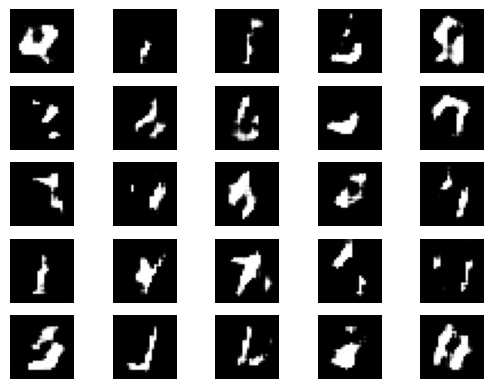

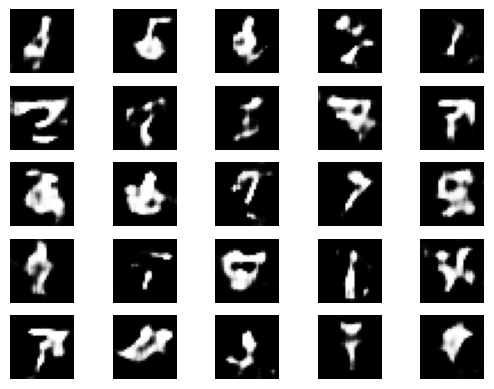

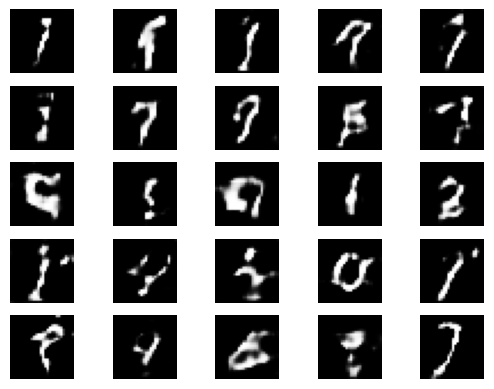

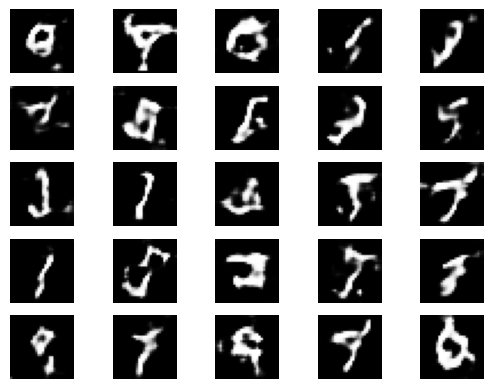

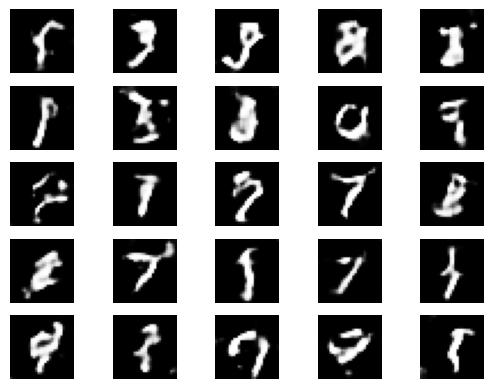

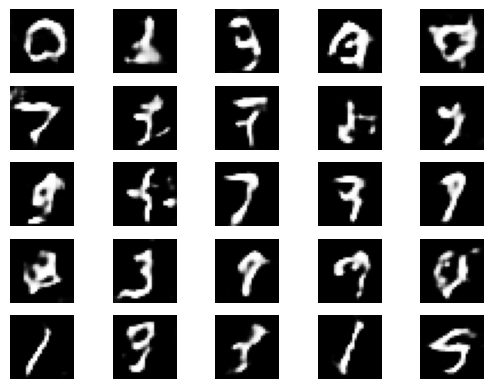

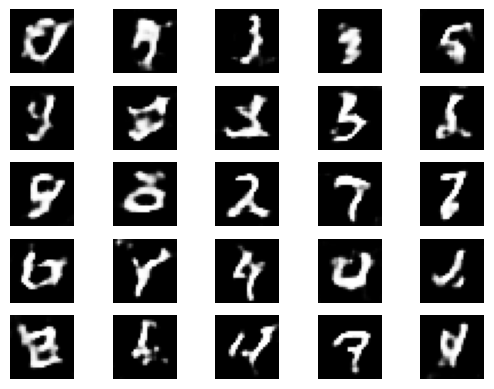

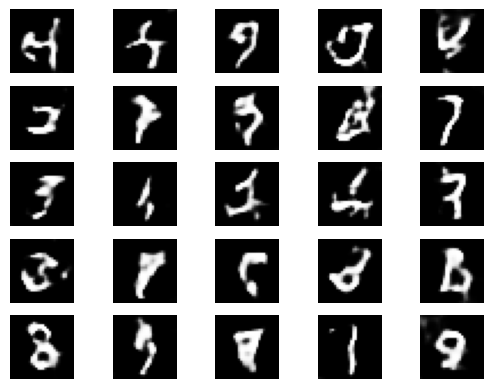

In [18]:
gan_train(2001, 32, 200)